In [109]:
!pip install pyLDAvis

In [110]:
import json
import pprint

import numpy as np
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from gensim import corpora, models
import pandas as pd
from sklearn.manifold import TSNE
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# Variables


In [111]:
num_topics = 2
use_title = False

# Data loading and preparation

## load

In [112]:
with open('data_jmlr_vol17.json') as f:
  data = json.load(f)
data_df = pd.json_normalize(data['papers'])
corpus = data_df["abstract"]
if use_title:
  corpus = data_df["title"] + " " + corpus 


## preprocess

In [113]:
### Preprocess the Dataset ### 
tokenized =[] 
for sentence in corpus: 
  # the simple_preprocess function returns a list of each sentence 
  tokenized.append(simple_preprocess(sentence ,min_len=2, max_len=15)) # the minimum length of a token and  maximum length of a token.
print(tokenized)


[['the', 'stochastic', 'multi', 'armed', 'bandit', 'model', 'is', 'simple', 'abstraction', 'that', 'has', 'proven', 'useful', 'in', 'many', 'different', 'contexts', 'in', 'statistics', 'and', 'machine', 'learning', 'whereas', 'the', 'achievable', 'limit', 'in', 'terms', 'of', 'regret', 'minimization', 'is', 'now', 'well', 'known', 'our', 'aim', 'is', 'to', 'contribute', 'to', 'better', 'understanding', 'of', 'the', 'performance', 'in', 'terms', 'of', 'identifying', 'the', 'best', 'arms', 'we', 'introduce', 'generic', 'notions', 'of', 'complexity', 'for', 'the', 'two', 'dominant', 'frameworks', 'considered', 'in', 'the', 'literature', 'fixed', 'budget', 'and', 'fixed', 'confidence', 'settings', 'in', 'the', 'fixed', 'confidence', 'setting', 'we', 'provide', 'the', 'first', 'known', 'distribution', 'dependent', 'lower', 'bound', 'on', 'the', 'complexity', 'that', 'involves', 'information', 'theoretic', 'quantities', 'and', 'holds', 'when', 'under', 'general', 'assumptions', 'in', 'the', 

In [114]:
dictionary = corpora.Dictionary(tokenized) 
BoW_corpus = [dictionary.doc2bow(text) for text in tokenized]

In [115]:
tfidf = models.TfidfModel(BoW_corpus)
corpus_tfidf = tfidf[BoW_corpus]

# LSI

## TFIDF

In [116]:
lsi_tfidf = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics)# train model
lsi_tfidf[corpus_tfidf[1]]  # apply model to  document

[]

## Bag of Words

In [117]:
lsi_bow = models.LsiModel(BoW_corpus, id2word=dictionary, num_topics=num_topics)
lsi_bow[BoW_corpus[1]]  # apply model to  document

[]

# LDA

## init

In [118]:
# LDA model training 
lda_model = models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

# Inspect

## Keywords

In [119]:
for keyword in data_df["keywords"]:
  print(keyword)

['multi-armed bandit', 'best-arm identification', 'pure exploration', 'information-     theoretic divergences', '']
['dictionary learning', 'multi-resolution analysis', 'manifold learning', 'robustness', 'sparsityc 2016 Mauro Maggioni', 'Stanislav Minsker', '']
['clustering', 'time series', 'ergodicity', '']
['feature rotation', 'ensemble diversity', '']
['statistical comparison', 'Friedman test', '']
['permutation estimation', 'minimax rate of separation', '']
['Markov chain Monte Carlo', 'Langevin dynamics', '']
['deep learning', 'neural networks', 'optimization', 'evolution of culture', 'curriculum     learning', '']
['string kernels', 'string distances', '']
['Gibbs sampling', 'herding', '']
[]
['Subspace clustering', 'robustness', 'stability', 'compressive sensing', '']
['Reinforcement learning', 'Markov decision processes', 'variance estimation', 'simulation', '']
['Statistical consistency', 'multiclass loss', 'loss matrix', 'surrogate loss', 'convex     surrogates', 'calibrated 

In [146]:
print(f"The Dataset contains {len(data_df)} Papers")
count_keywords = 0
all_keywords = []
for keyword in data_df["keywords"]:
  if keyword and keyword[0]:
    count_keywords += 1
    all_keywords = all_keywords + keyword
print(f"{count_keywords} of them contain Keywords.")
print(f"There are {len(all_keywords)} Keywords. {len(set(all_keywords))} of them are unique.")


The Dataset contains 236 Papers
203 of them contain Keywords.
There are 1023 Keywords. 707 of them are unique.


## Corpus

In [120]:
pprint.pprint(dictionary.token2id)#token -> tokenId.

{'abernethy': 3004,
 'ability': 1571,
 'able': 1303,
 'abnormal': 3671,
 'about': 749,
 'above': 2417,
 'absence': 2672,
 'absent': 3672,
 'abstraction': 0,
 'accelerate': 2637,
 'accelerated': 2966,
 'accelerometer': 3673,
 'accelerometry': 3674,
 'accept': 403,
 'acceptance': 404,
 'accepted': 3092,
 'access': 1903,
 'accessible': 2788,
 'accidents': 4021,
 'accommodate': 2609,
 'accommodates': 3771,
 'accompany': 1144,
 'accomplish': 3851,
 'accomplished': 3951,
 'accordance': 3483,
 'according': 1020,
 'account': 873,
 'accounts': 4039,
 'accuracy': 217,
 'accurate': 218,
 'accurately': 2132,
 'achievable': 1,
 'achieve': 219,
 'achieved': 1205,
 'achieves': 840,
 'achieving': 2402,
 'acquired': 3975,
 'acquiring': 2227,
 'acquisition': 3361,
 'across': 1437,
 'act': 2472,
 'action': 946,
 'actions': 2981,
 'activation': 3622,
 'activations': 3123,
 'active': 2467,
 'activity': 2995,
 'actor': 1994,
 'actual': 947,
 'acyclic': 1237,
 'ad': 3745,
 'adaboost': 2073,
 'adaframe': 3124

In [121]:
pprint.pprint(dictionary.dfs) # token_id -> how many documents contain this token.

{0: 1,
 1: 2,
 2: 20,
 3: 6,
 4: 70,
 5: 12,
 6: 73,
 7: 4,
 8: 222,
 9: 142,
 10: 3,
 11: 2,
 12: 16,
 13: 10,
 14: 6,
 15: 3,
 16: 111,
 17: 8,
 18: 2,
 19: 12,
 20: 21,
 21: 68,
 22: 25,
 23: 31,
 24: 4,
 25: 34,
 26: 1,
 27: 21,
 28: 4,
 29: 7,
 30: 3,
 31: 1,
 32: 2,
 33: 9,
 34: 28,
 35: 3,
 36: 39,
 37: 37,
 38: 1,
 39: 31,
 40: 1,
 41: 38,
 42: 15,
 43: 204,
 44: 2,
 45: 5,
 46: 31,
 47: 41,
 48: 7,
 49: 7,
 50: 68,
 51: 57,
 52: 2,
 53: 7,
 54: 14,
 55: 205,
 56: 15,
 57: 6,
 58: 33,
 59: 9,
 60: 29,
 61: 1,
 62: 193,
 63: 28,
 64: 107,
 65: 3,
 66: 8,
 67: 16,
 68: 19,
 69: 44,
 70: 40,
 71: 8,
 72: 24,
 73: 13,
 74: 15,
 75: 61,
 76: 57,
 77: 25,
 78: 2,
 79: 1,
 80: 26,
 81: 2,
 82: 23,
 83: 221,
 84: 166,
 85: 107,
 86: 34,
 87: 67,
 88: 6,
 89: 2,
 90: 4,
 91: 55,
 92: 4,
 93: 2,
 94: 9,
 95: 7,
 96: 79,
 97: 6,
 98: 5,
 99: 3,
 100: 6,
 101: 38,
 102: 16,
 103: 1,
 104: 102,
 105: 32,
 106: 4,
 107: 21,
 108: 5,
 109: 10,
 110: 20,
 111: 2,
 112: 1,
 113: 6,
 114: 26,
 1

In [122]:
pprint.pprint(BoW_corpus)# list of (token_id, token_count) 

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  (738, 1),
  (739, 1),
  (751, 1),
  (802, 3),
  (806, 1),
  (820, 1),
  (822, 1),
  (863, 1),
  (872, 1),
  (885, 1),
  (1035, 1),
  (1096, 1),
  (1123, 1),
  (1127, 2),
  (1223, 1),
  (1278, 1),
  (1293, 1),
  (1391, 1),
  (1455, 2),
  (1473, 1),
  (1516, 1),
  (1573, 1),
  (1574, 1),
  (1690, 1),
  (1725, 1),
  (1817, 1),
  (1889, 3),
  (1938, 1),
  (1999, 1),
  (2263, 1),
  (2274, 1),
  (2279, 1),
  (2558, 1),
  (2563, 1),
  (2570, 1),
  (2622, 1),
  (2748, 1),
  (3167, 1),
  (3642, 2),
  (3643, 1),
  (3644, 1),
  (3645, 1),
  (3646, 1),
  (3647, 1),
  (3648, 1),
  (3649, 2),
  (3650, 1)],
 [(8, 5),
  (16, 2),
  (22, 1),
  (39, 1),
  (43, 4),
  (47, 1),
  (55, 4),
  (62, 2),
  (83, 6),
  (84, 2),
  (91, 1),
  (101, 1),
  (116, 1),
  (118, 8),
  (122, 2),
  (127, 5),
  (131, 5),
  (133, 6),
  (136, 2),
  (141, 1),
  (142, 1),
  (144, 6),
  (146, 1),
  (147, 1),
  (148, 2),
  (155, 2),
  (163, 1),
  (173, 1),
  (181,

TODO: You can furthur filter and clean your data by using functions such as filter_extremes (remove all tokens that are less frequent or more frequent than a number), filter_n_most_frequent(filter out the ‘remove_n’ most frequent tokens), merge_with (to merge multiple dictionaries)

In [123]:
for doc in corpus_tfidf:
    print(doc)

[(0, 0.10664379102630347), (1, 0.09311485278078224), (2, 0.04817269272898915), (3, 0.07167199298705884), (4, 0.023721099600732994), (5, 0.05814305474153761), (6, 0.022902036818605056), (7, 0.07958591453526102), (8, 0.008355340773794465), (9, 0.009915303775431362), (10, 0.17040186246516012), (11, 0.09311485278078224), (12, 0.05252803804421857), (13, 0.06170163097451037), (14, 0.21501597896117652), (15, 0.08520093123258006), (16, 0.014722558356063292), (17, 0.06605697628973979), (18, 0.09311485278078224), (19, 0.05814305474153761), (20, 0.04722039985880268), (21, 0.024286882175122447), (22, 0.04381734741375972), (23, 0.03961877508689033), (24, 0.23875774360578306), (25, 0.03781582042064367), (26, 0.10664379102630347), (27, 0.1888815994352107), (28, 0.3183436581410441), (29, 0.06866325965252608), (30, 0.08520093123258006), (31, 0.10664379102630347), (32, 0.09311485278078224), (33, 0.06375807143885663), (34, 0.04160538316148364), (35, 0.08520093123258006), (36, 0.03513791080457525), (37, 0

## Topics

In [124]:
lsi_tfidf.print_topics()

[(0,
  '0.109*"learning" + 0.096*"model" + 0.093*"data" + 0.091*"kernel" + 0.085*"method" + 0.084*"regression" + 0.082*"bounds" + 0.081*"our" + 0.081*"models" + 0.081*"as"'),
 (1,
  '0.237*"lpcc" + 0.203*"causal" + 0.162*"latent" + -0.161*"multiclass" + -0.152*"losses" + -0.140*"loss" + -0.139*"norm" + 0.139*"variables" + -0.131*"svm" + 0.127*"inference"')]

In [125]:
lsi_bow.print_topics()

[(0,
  '0.663*"the" + 0.417*"of" + 0.271*"and" + 0.239*"to" + 0.202*"in" + 0.180*"we" + 0.152*"is" + 0.148*"for" + 0.134*"that" + 0.101*"on"'),
 (1,
  '-0.664*"the" + 0.365*"and" + 0.336*"of" + 0.270*"to" + 0.212*"we" + 0.141*"for" + 0.115*"data" + 0.098*"our" + 0.098*"that" + 0.085*"learning"')]

In [126]:
lda_model.print_topics()

[(0,
  '0.001*"fdm" + 0.000*"linkage" + 0.000*"rc" + 0.000*"lpcc" + 0.000*"submodular" + 0.000*"sdca" + 0.000*"duality" + 0.000*"multiclass" + 0.000*"linearly" + 0.000*"errata"'),
 (1,
  '0.002*"svm" + 0.001*"our" + 0.001*"risk" + 0.001*"model" + 0.001*"linkage" + 0.001*"algorithms" + 0.001*"lpcc" + 0.001*"algorithm" + 0.001*"hierarchical" + 0.001*"norm"')]

## Plot

In [127]:
def plot_2d_space(corpus, method, use_tsne=False):

  if isinstance(method, models.ldamodel.LdaModel):
    documents_2d_1=[x[0][0][1] for x in method[corpus] if x]
    documents_2d_2=[x[0][1][1] for x in list(method[corpus]) if x]
  else:
    documents_2d_1=[x[0][1] for x in method[corpus] if x]
    documents_2d_2=[x[1][1] for x in list(method[corpus]) if x]


  fig, ax = plt.subplots(figsize=(10,10))

  # Get topic weights
  topic_weights = []
  for i, row_list in enumerate(method[corpus]):
    if row_list:
      if isinstance(method, models.ldamodel.LdaModel):
        topic_weights.append([w for i, w in row_list[0]])
      else:
        topic_weights.append([w for i, w in row_list])

  # Array of topic weights    
  arr = pd.DataFrame(topic_weights).fillna(0).values

  # Dominant topic number in each doc
  topic_num = np.argmax(arr, axis=1)

  if use_tsne:
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99)
    tsne = tsne_model.fit_transform(arr)
    documents_2d_1 = tsne[:,0]
    documents_2d_2 = tsne[:,1]

  ax.scatter(documents_2d_1, documents_2d_2, c=topic_num, s=80 ,alpha=0.8)
  for i in range(len(documents_2d_1)):
      ax.annotate(i, (documents_2d_1[i], documents_2d_2[i]))

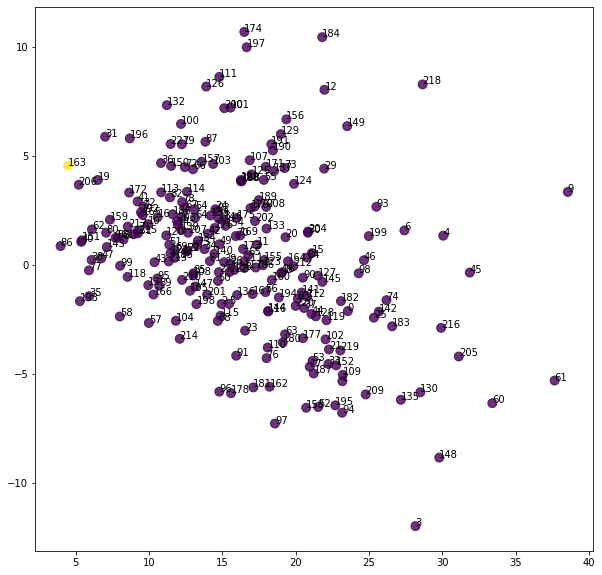

In [128]:
plot_2d_space(BoW_corpus, lsi_bow)

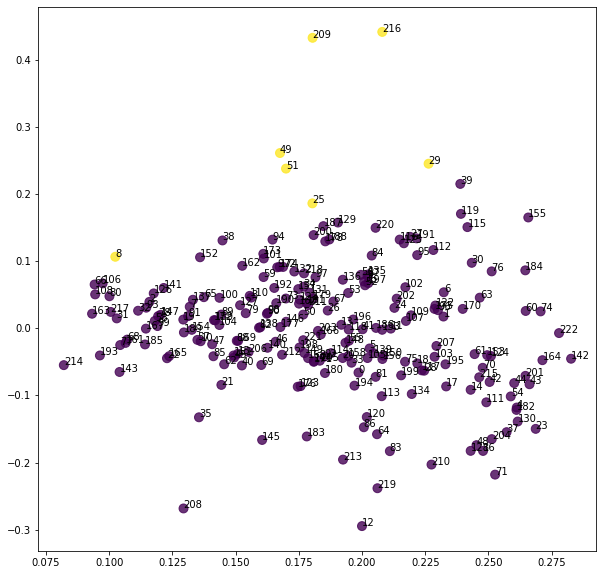

In [129]:
plot_2d_space(corpus_tfidf, lsi_tfidf)

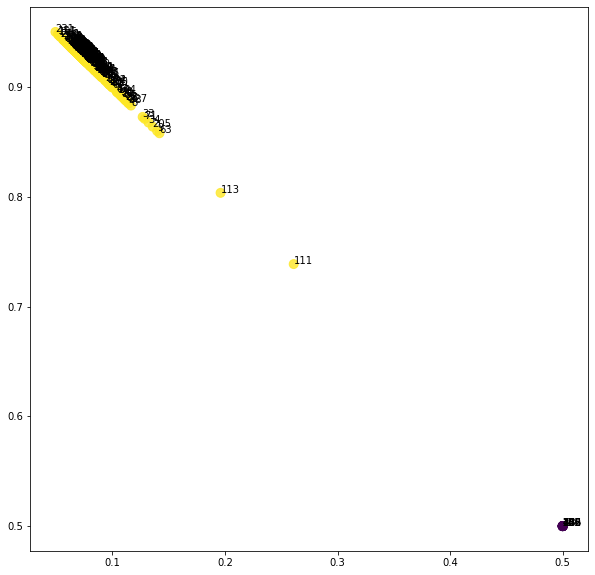

In [130]:
plot_2d_space(corpus_tfidf, lda_model)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 236 samples in 0.000s...
[t-SNE] Computed neighbors for 236 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 236 / 236
[t-SNE] Mean sigma: 0.002418
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.095444
[t-SNE] KL divergence after 700 iterations: 0.076966


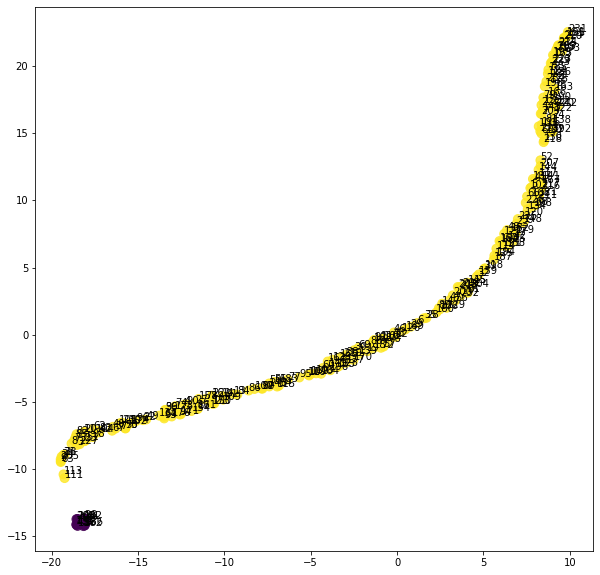

In [131]:
plot_2d_space(corpus_tfidf, lda_model, use_tsne=True)

In [132]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus_tfidf, dictionary=lda_model.id2word, mds='mmds')

In [133]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.000928 -0.016373       1        1  92.337717
0      0.000928  0.016373       2        1   7.662283, topic_info=              Term      Freq     Total Category  logprob  loglift
4012           fdm  1.000000  1.000000  Default  30.0000  30.0000
4014            rc  0.000000  0.000000  Default  29.0000  29.0000
4010       duality  0.000000  0.000000  Default  28.0000  28.0000
4015          sdca  0.000000  0.000000  Default  27.0000  27.0000
4013      linearly  0.000000  0.000000  Default  26.0000  26.0000
...            ...       ...       ...      ...      ...      ...
2630        newton  0.037178  0.941494   Topic2  -8.1582  -0.6629
4044       chronic  0.036893  0.802206   Topic2  -8.1659  -0.5105
765           mdps  0.036892  0.810638   Topic2  -8.1659  -0.5210
911        subject  0.036954  0.993735   Topic2  -8.1642  -0.7229
667   hierarchical  0.037045  1.838291   Topic2  -8.1618  -1.3356

[184 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3746      1  1.716110   advertiser
133       1  1.073550    algorithm
4         1  1.054526   algorithms
222       1  1.237727     approach
9         1  1.296948          are
...     ...       ...          ...
118       1  0.656552          the
554       1  1.243150     training
338       1  1.172712        using
628       1  0.655408    variables
1570      1  1.130858  variational

[61 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])